In [1]:
import os
from dotenv import load_dotenv
from matplotlib import pyplot as plt

from quantuminspire.credentials import enable_account
from quantuminspire.qiskit import QI

from qiskit_aer import Aer

from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper

from src.qiskit.evaluation import manual_vqe
from src.qiskit.evaluation.hydrogen_system.hydrogen_system import HydrogenSystem

# Running VQE on Quantum Inspire

> [Quantum Inspire SDK](https://github.com/QuTech-Delft/quantuminspire)

For a detailed installation guide and additional documentation on the QI SDK rever to the link above.

The following code snippet demonstrates how to run a VQE calculation on Quantum Inspire using the Qiskit library.

First step in running your quantum circuit on the available Quantum Inspire backends is to enable your account. Using Python dotenv library, you can store your API token in a `.env` file and load it into your script. With this token you can enable your account and set the project name. If you do not set your project name, QI will create a new project with a default name. For VQE this is a problem since you have to call the backend multiple times to evaluate the cost function.

To see all available QI backends you can check them on the website in [your account](https://www.quantum-inspire.com/projects).

In [2]:
load_dotenv()
api_token = os.getenv('QI_API_TOKEN')

project_name = 'Orbitals - Speeding up Chemistry Simulations'

enable_account(api_token)
QI.set_authentication(project_name=project_name)

# qi_backend = QI.get_backend('Starmon-5')
qi_backend = QI.get_backend('QX single-node simulator')
simulated_backend = Aer.get_backend("qasm_simulator")

/var/folders/6s/q0ttmhtn4jn5782f1n91hg8h0000gn/T/ipykernel_2236/1414010783.py:10: DeprecationWarning: The method ``qiskit.providers.provider.ProviderV1.get_backend()`` is deprecated as of qiskit 1.1. It will be removed no earlier than 3 months after the release date. The abstract Provider and ProviderV1 classes are deprecated and will  be removed in 2.0. You can just remove it as the parent class and a `get_backend` method that returns the backends from `self.backend`.
  qi_backend = QI.get_backend('QX single-node simulator')


## Running VQE and defining Hydrogen System

We use the hydrogen system described in other examples, with the option to choose type of mapper.

We use an bond length of 0.735 Ångström, close to the ideal bond length at ground state level for hydrogen.

In [3]:
hydrogen_num_particles = (1, 1)

jordan_wigner_mapper = JordanWignerMapper()
parity_mapper = ParityMapper(num_particles=hydrogen_num_particles)

hydrogen_system = HydrogenSystem(0.735, parity_mapper, use_tapered_mapper=True)

We can now run the VQE using our Quantum Inspire backend.

## Starmon-5

Running on QI Starmon-5 backend mandates exactly 5 qubits, necessitating modifications to the Hamiltonian to fit within a 5-qubit circuit. Consequently, we are unable to use the Qiskit Nature ansatz and instead employ `EfficientSU2` from `qiskit.circuit.library` to create the ansatz. These changes significantly reduce optimization in the ansatz, resulting in a higher circuit depth compared to the single-gate circuit seen in qiskit/qiskit_manual_vqe.ipynb. A single calculation on QI's Starmon-5 takes approximately 1 second (average of 42 calculations with tapered parity mapper).

Code needed to change the circuit is below, apart from that the code is the same as the one used for the Qasm simulator.

```python
from qiskit import QuantumRegister
from qiskit.circuit.library import EfficientSU2
from qiskit.transpiler import transpile

# Extend Hamiltonian for 5 qubits
extended_hamiltonian = SparsePauliOp.from_list([
    (pauli + 'I' * 4, coefficient)  
    for pauli, coefficient in hamiltonian.to_list()
])

# Transpile ansatz for Starmon-5
ansatz = EfficientSU2(extended_hamiltonian.num_qubits)
# quantum inspire backend does not have a target, so we can't use the pass manager
ansatz_isa = transpile(ansatz, backend=starmon5_backend)

num_params = ansatz_isa.num_parameters
```

In [4]:
result, cost_history = manual_vqe.vqe_calculation(0.735, hydrogen_system, backend=simulated_backend)

print(result)

SparsePauliOp(['IIIII', 'XIIII', 'ZIIII'],
              coeffs=[-1.04109314+0.j, -0.1809312 +0.j, -0.79587485+0.j])
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.1391433280121497
       x: [ 5.688e-02  5.778e-03 ...  1.016e+00 -4.047e-03]
    nfev: 361
   maxcv: 0.0


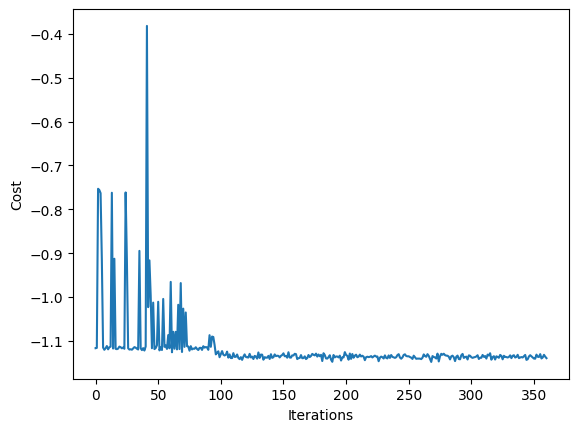

In [5]:
fig, ax = plt.subplots()
ax.plot(range(cost_history["iters"]), cost_history["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()